In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
from matplotlib.image import imread
import cv2
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import plot_model
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

In [ ]:
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.metrics import *
from collections import Counter
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.utils import compute_class_weight
from sklearn.model_selection import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

# Mammography ROI Cancer Detection

### Helper Functions

In [ ]:

def plot_loss_curves(history):
  """
  Returns separate lass curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))# how many epochs did we run for?

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("model loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("model accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [ ]:
def img_pred(arr,test_arr,index,model):
    plt.title('Test Image')
    plt.imshow(arr[index])
    input = arr[index:index+1]
    pred = model.predict(input)[0].argmax()
    label = test_arr[index].argmax()
    print('Predicted Value Using CNN Model:',pred)
    print("True Value:",label)

In [ ]:
def visualize_conf_mat(true_labels, predicted_labels):
  '''
  Visualize confusion matrix also in percentage.
  '''
  predicted_classes = np.argmax(predicted_labels, axis = 1)
  # create subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # plot confusion matrix
  confusion_mtx = confusion_matrix(true_labels, predicted_classes)
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt= '.1f', ax=ax1)
  ax1.set_xlabel("Predicted Label")
  ax1.set_ylabel("True Label")
  ax1.set_title("Confusion Matrix")

  # plot confusion matrix percentage
  confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100
  sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax2)
  ax2.set_xlabel("Predicted Label")
  ax2.set_ylabel("True Label")
  ax2.set_title("Confusion Matrix (Percentage)")

  plt.show()

### Get Data

In [ ]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [ ]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        #image=cv2.merge([image,image,image])
        #image
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [ ]:
filenames=['../input/ddsm-mammography/training10_0/training10_0.tfrecords',
          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
          '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
          '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
          '../input/ddsm-mammography/training10_4/training10_4.tfrecords']

for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None

In [ ]:
images[1]

array([[46, 49, 48, ..., 56, 57, 57],
       [47, 47, 48, ..., 56, 56, 59],
       [46, 47, 46, ..., 55, 57, 60],
       ...,
       [61, 64, 61, ..., 70, 69, 71],
       [62, 63, 59, ..., 69, 69, 71],
       [59, 64, 62, ..., 68, 72, 71]], dtype=uint8)

In [ ]:
images[1].shape

(100, 100)

In [ ]:
X=np.array(images)
y=np.array(labels)
i=0
for value in y:
    if value == 1:
        i=i+1
print(f"Length of Non cancer images is {i}")
i=0
for value in y:
    if value == 0:
        i=i+1
print(f"Length of Cancer images is {i}")
print(f"Total number of images {len(y)}")

Length of Non cancer images is 7289
Length of Cancer images is 48596
Total number of images 55885


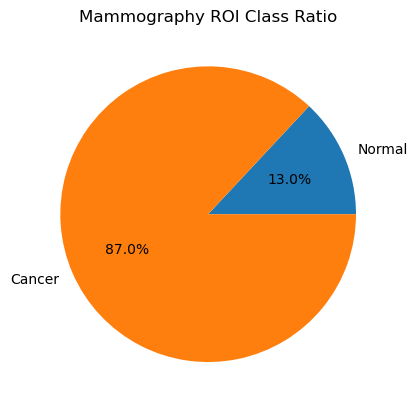

In [ ]:
counts = [7289,48596]
labels = ['Normal', 'Cancer']

plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Mammography ROI Class Ratio')
plt.show()

**We can say our data is unbalanced.**

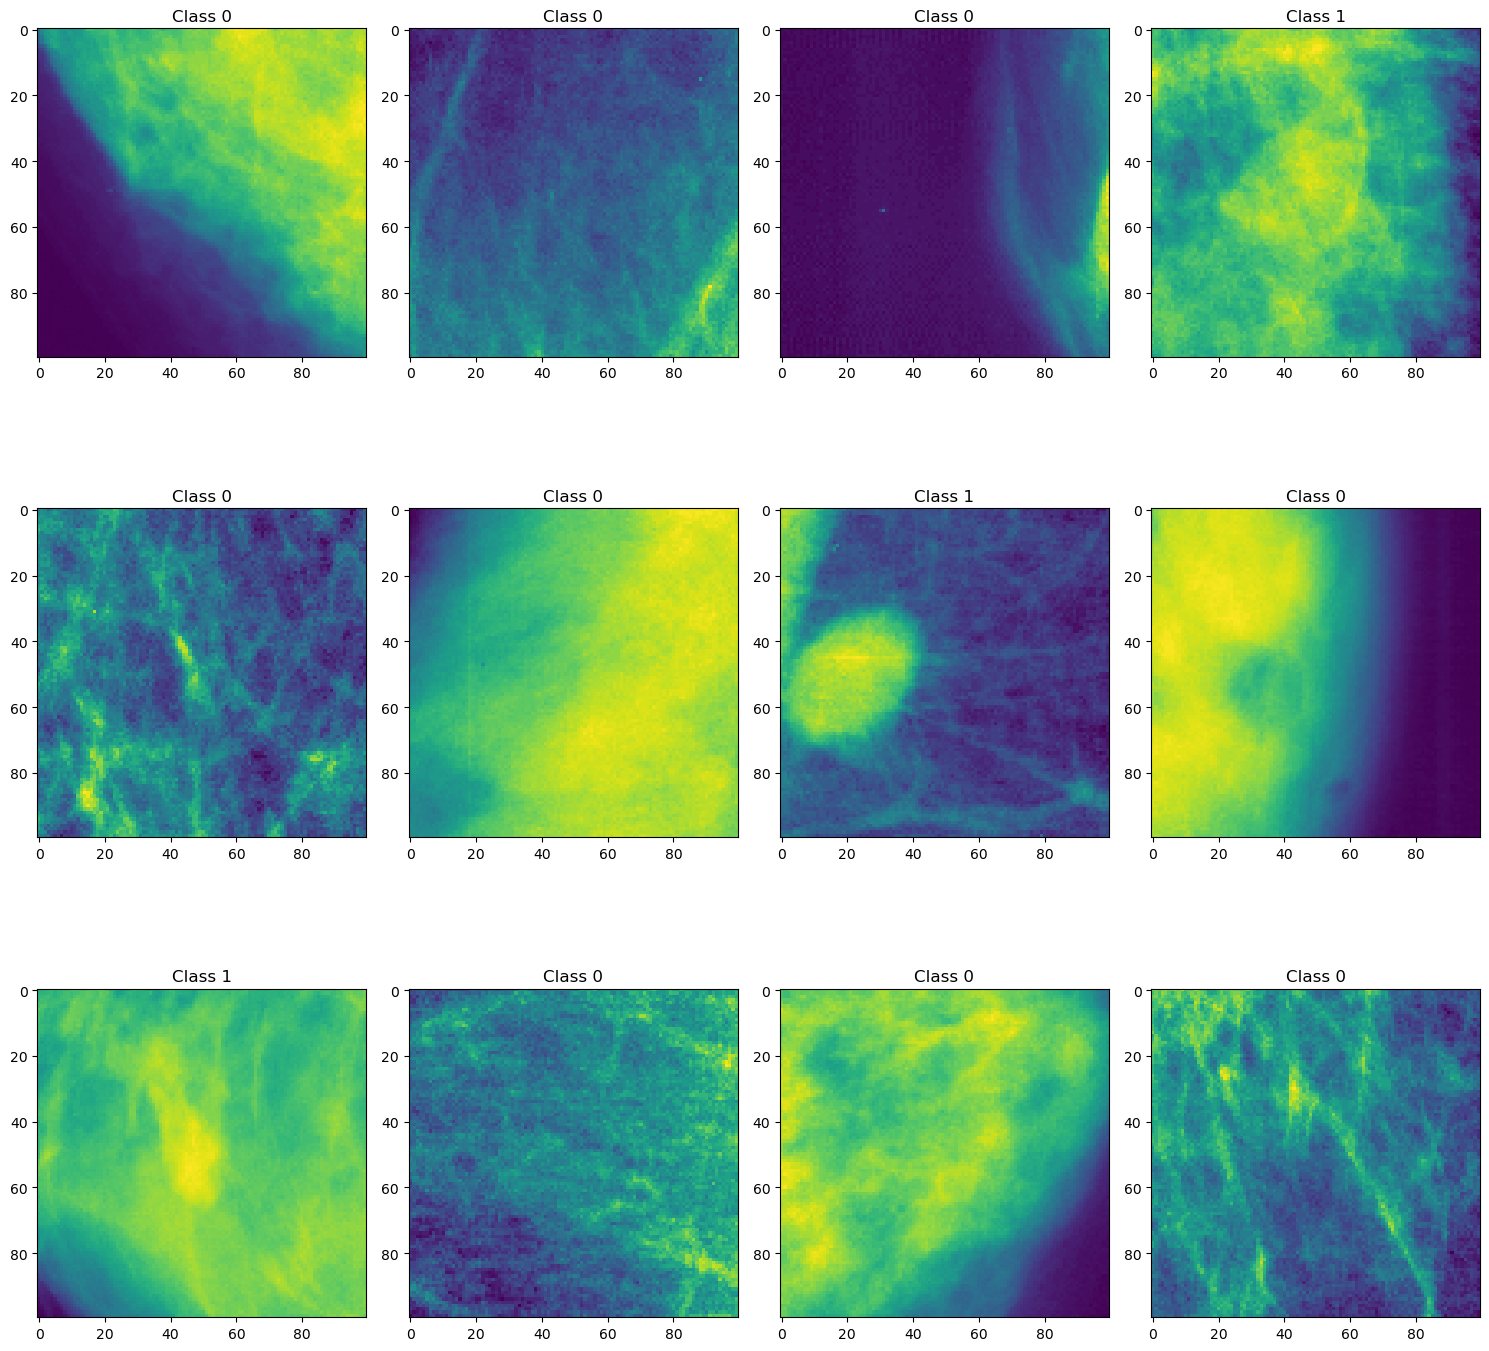

In [ ]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns * rows + 1):
    img = X[i-1]  # Get the i-th selected image
    label = f"Class {y[i-1]}"  # Get the corresponding label
    ax = fig.add_subplot(rows, columns, i)
    ax.imshow(img)
    ax.set_title(label, fontsize=12, pad=5)  # Add the label as the title

plt.tight_layout()
plt.show()

# Unbalanced Data Set

In [ ]:
X=np.array(images)
y=np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True,stratify=y)
#add channel one to X sets
(a,b,c)=X_train.shape
X_train = np.reshape(X_train, (a, b, c, 1))
(a, b, c)=X_test.shape
X_test = np.reshape(X_test, (a, b, c, 1))

In [ ]:
X_train.shape

(44708, 100, 100, 1)

# Undersample Majority Class

In [ ]:
random_state=42
# Find the indices of images labeled as 0
zero_indices = np.where(y == 0)[0]

# Randomly select 7289 indices from the zero_indices
selected_indices = np.random.choice(zero_indices, size=8500, replace=False)

# Use the selected indices to get the corresponding images and labels
selected_images = X[selected_indices]
selected_labels = y[selected_indices]

In [ ]:
# Find the indices of images labeled as 1
one_indices = np.where(y == 1)[0]

# Use the one_indices to get all images and labels of class 1
selected_images_1 = X[one_indices]
selected_labels_1 = y[one_indices]

# Combine the images and labels of class 0 and class 1
combined_images = np.concatenate((selected_images, selected_images_1), axis=0)
combined_labels = np.concatenate((selected_labels, selected_labels_1), axis=0)

In [ ]:
combined_images[1].shape, combined_labels[1],combined_images.shape, combined_labels.shape

((100, 100), 0, (15789, 100, 100), (15789,))

In [ ]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42,shuffle=True,stratify=combined_labels)
(a,b,c)=X_train_b.shape
X_train_b = np.reshape(X_train_b, (a, b, c, 1))
(a, b, c)=X_test_b.shape
X_test_b = np.reshape(X_test_b, (a, b, c, 1))

In [ ]:
print(X_train_b.shape)

(12631, 100, 100, 1)


In [ ]:
X_test_b.shape,y_test_b.shape

((3158, 100, 100, 1), (3158,))

In [ ]:

i=0
for value in y_test_b:
    if value == 1:
        i=i+1
print(f"Length of Non cancer Balance Test images is {i}")
i=0
for value in y_test_b:
    if value == 0:
        i=i+1
print(f"Length of Cancer Balance Test images is {i}")
print(f"Total number of images {len(y_test_b)}")

Length of Non cancer images is 1458
Length of Cancer images is 1700
Total number of images 3158


# Model 1

In [ ]:
rows, cols,color = X_train[0].shape

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1),input_shape=(rows,cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=20,restore_best_weights=True, verbose=1)
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

## Fit unbalanced data to model 1

In [ ]:
history_1 = model.fit(X_train, y_train,validation_split=0.2,shuffle=True, epochs=20, batch_size=64 ,callbacks=[es])

Epoch 1/20


2023-06-22 13:12:27.626012: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


559/559 [==============================] - 34s 36ms/step - loss: 0.4469 - accuracy: 0.8647 - val_loss: 0.5396 - val_accuracy: 0.8711
Epoch 2/20
559/559 [==============================] - 19s 34ms/step - loss: 0.3060 - accuracy: 0.8713 - val_loss: 0.6093 - val_accuracy: 0.8731
Epoch 3/20
559/559 [==============================] - 18s 33ms/step - loss: 0.2873 - accuracy: 0.8792 - val_loss: 0.4503 - val_accuracy: 0.8832
Epoch 4/20
559/559 [==============================] - 18s 33ms/step - loss: 0.2705 - accuracy: 0.8829 - val_loss: 0.5004 - val_accuracy: 0.8820
Epoch 5/20
559/559 [==============================] - 19s 33ms/step - loss: 0.2545 - accuracy: 0.8897 - val_loss: 0.4195 - val_accuracy: 0.8855
Epoch 6/20
559/559 [==============================] - 19s 33ms/step - loss: 0.2492 - accuracy: 0.8934 - val_loss: 0.4762 - val_accuracy: 0.8878
Epoch 7/20
559/559 [==============================] - 19s 34ms/step - loss: 0.2329 - accuracy: 0.8992 - val_loss: 0.4132 - val_accuracy: 0.8900
Epo

## Results

In [ ]:
loss_value , accuracy = model.evaluate(X_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

350/350 [==============================] - 3s 7ms/step - loss: 0.3029 - accuracy: 0.9012
Test_loss_value = 0.3029346466064453
test_accuracy = 0.901225745677948


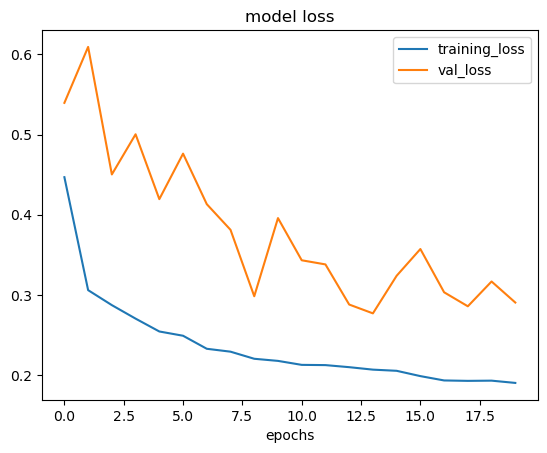

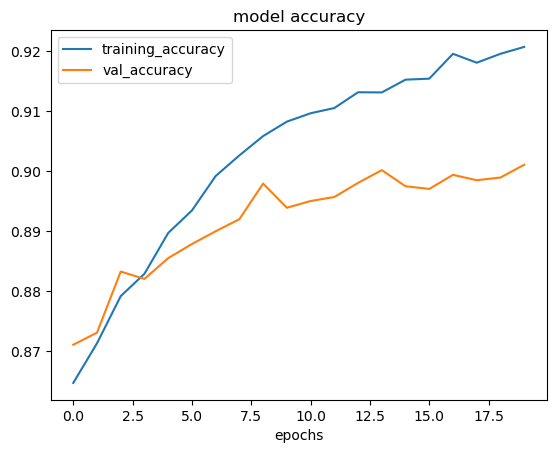

In [ ]:
plot_loss_curves(history_1)

In [ ]:
Y_pred_1 = model.predict(X_test)

350/350 [==============================] - 2s 4ms/step


In [ ]:
print(classification_report(y_test, np.argmax(Y_pred_1,axis = 1)))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      9719
           1       0.00      0.00      0.00      1458

    accuracy                           0.87     11177
   macro avg       0.43      0.50      0.47     11177
weighted avg       0.76      0.87      0.81     11177



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


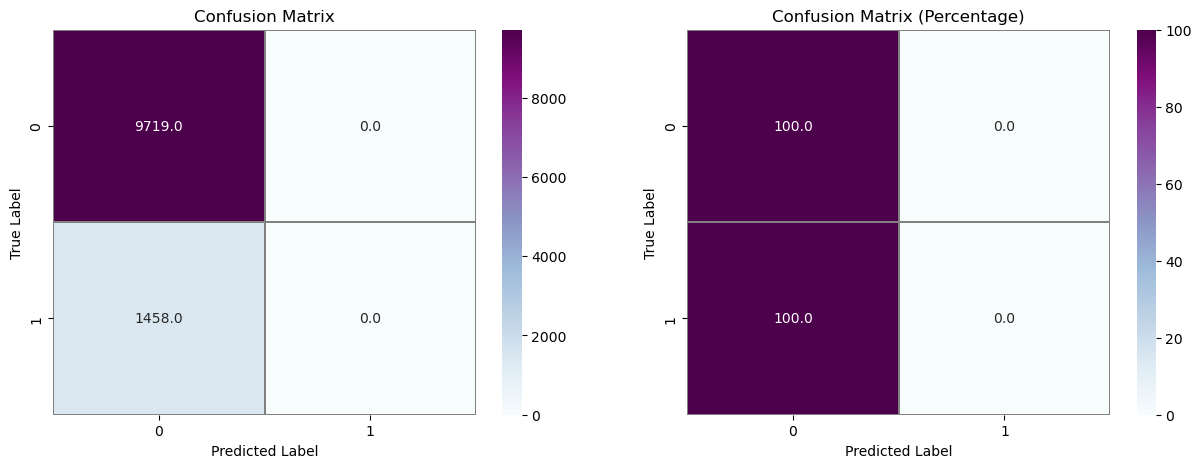

In [ ]:
visualize_conf_mat(y_test,Y_pred_1)

In [ ]:
model.save('model_1_mam.h5')

## Fit the model 1 with balanced data

In [ ]:
history_2 = model.fit(X_train_b, y_train_b,validation_split=0.2,shuffle=True, epochs=20, batch_size=64 ,callbacks=[es])

Epoch 1/20
158/158 [==============================] - 6s 39ms/step - loss: 0.3291 - accuracy: 0.8546 - val_loss: 0.6251 - val_accuracy: 0.7020
Epoch 2/20
158/158 [==============================] - 5s 33ms/step - loss: 0.2825 - accuracy: 0.8689 - val_loss: 0.6844 - val_accuracy: 0.6810
Epoch 3/20
158/158 [==============================] - 5s 32ms/step - loss: 0.2765 - accuracy: 0.8755 - val_loss: 0.5220 - val_accuracy: 0.7614
Epoch 4/20
158/158 [==============================] - 5s 33ms/step - loss: 0.2825 - accuracy: 0.8667 - val_loss: 0.5743 - val_accuracy: 0.7404
Epoch 5/20
158/158 [==============================] - 5s 33ms/step - loss: 0.2733 - accuracy: 0.8739 - val_loss: 0.5057 - val_accuracy: 0.7127
Epoch 6/20
158/158 [==============================] - 5s 33ms/step - loss: 0.2791 - accuracy: 0.8727 - val_loss: 0.5608 - val_accuracy: 0.7388
Epoch 7/20
158/158 [==============================] - 5s 33ms/step - loss: 0.2640 - accuracy: 0.8806 - val_loss: 0.5456 - val_accuracy: 0.7539

## Results

In [ ]:
loss_value , accuracy = model.evaluate(X_test_b, y_test_b)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

99/99 [==============================] - 1s 8ms/step - loss: 0.3852 - accuracy: 0.8100
Test_loss_value = 0.3851681351661682
test_accuracy = 0.810006320476532


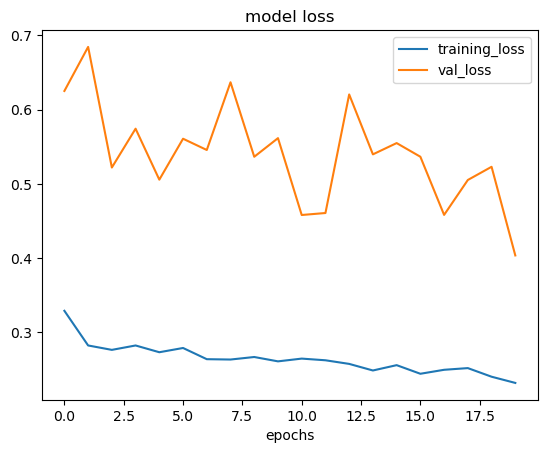

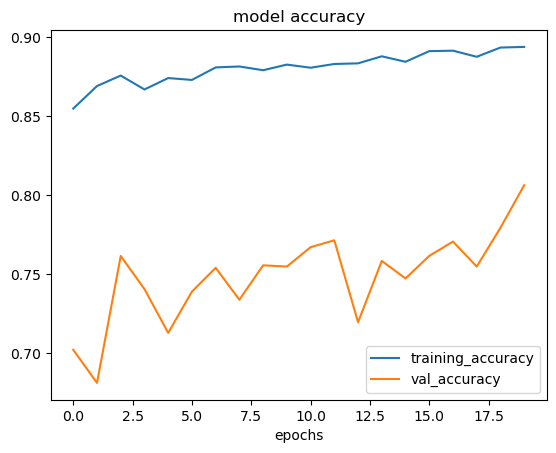

In [ ]:
plot_loss_curves(history_2)

In [ ]:
Y_pred_2 = model.predict(X_test_b)

99/99 [==============================] - 0s 4ms/step


In [ ]:
Y_pred_2.shape, np.argmax(Y_pred_2,axis = 1).shape, np.argmax(Y_pred_2,axis = 1)[0]

((3158, 1), (3158,), 0)

In [ ]:
report = classification_report(y_test_b, np.argmax(Y_pred_2,axis = 1), zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1700
           1       1.00      0.00      0.00      1458

    accuracy                           0.54      3158
   macro avg       0.77      0.50      0.35      3158
weighted avg       0.75      0.54      0.38      3158



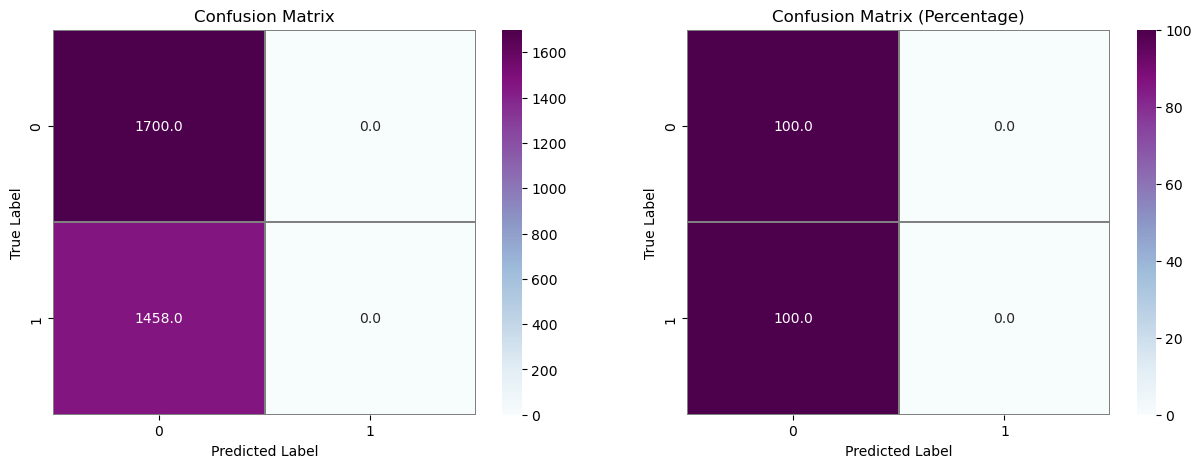

In [ ]:
visualize_conf_mat(y_test_b,Y_pred_2)

In [ ]:
model.save('model_2_mam.h5')

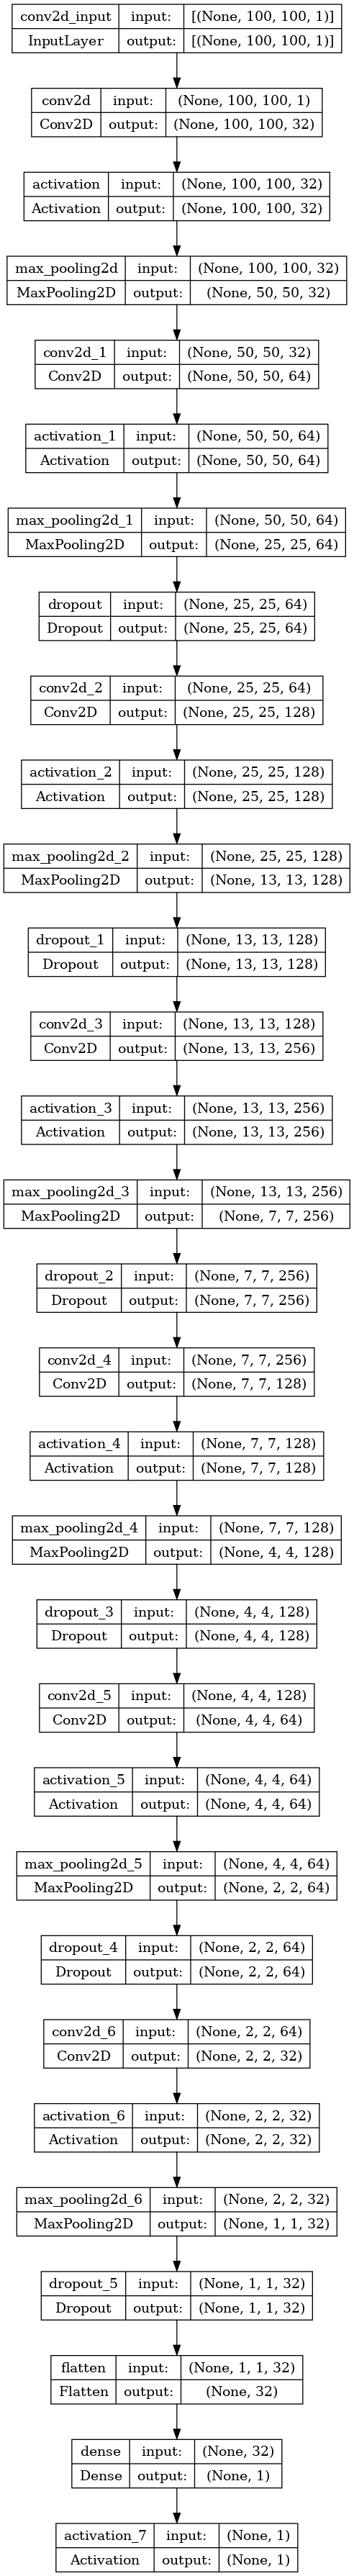

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_1_mam.png', show_shapes=True)

# Model 2

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5)

model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.3),
    Dense(24, activation='relu', kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

## Fit model 2 with Unbalanced Data

In [ ]:
history_3 = model_2.fit(X_train, y_train, validation_split=0.2,shuffle=True, epochs=10, batch_size=128 ,callbacks=[es])

Epoch 1/10
280/280 [==============================] - 46s 156ms/step - loss: 0.1298 - accuracy: 0.9449 - val_loss: 0.2520 - val_accuracy: 0.9204
Epoch 2/10
280/280 [==============================] - 43s 153ms/step - loss: 0.1191 - accuracy: 0.9505 - val_loss: 0.2630 - val_accuracy: 0.9206
Epoch 3/10
280/280 [==============================] - 44s 157ms/step - loss: 0.1101 - accuracy: 0.9550 - val_loss: 0.4776 - val_accuracy: 0.9077
Epoch 4/10
280/280 [==============================] - 44s 156ms/step - loss: 0.1012 - accuracy: 0.9587 - val_loss: 0.2128 - val_accuracy: 0.9396
Epoch 5/10
280/280 [==============================] - 44s 156ms/step - loss: 0.0905 - accuracy: 0.9629 - val_loss: 0.2340 - val_accuracy: 0.9345
Epoch 6/10
280/280 [==============================] - 44s 156ms/step - loss: 0.0814 - accuracy: 0.9656 - val_loss: 0.5784 - val_accuracy: 0.9023
Epoch 7/10
280/280 [==============================] - 44s 157ms/step - loss: 0.0744 - accuracy: 0.9701 - val_loss: 0.4326 - val_ac

## Results

In [ ]:
loss_value , accuracy = model_2.evaluate(X_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

Exception ignored in: <function _xla_gc_callback at 0x7acd4b8972e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


350/350 [==============================] - 3s 9ms/step - loss: 0.6842 - accuracy: 0.9057
Test_loss_value = 0.6841617822647095
test_accuracy = 0.9056991934776306


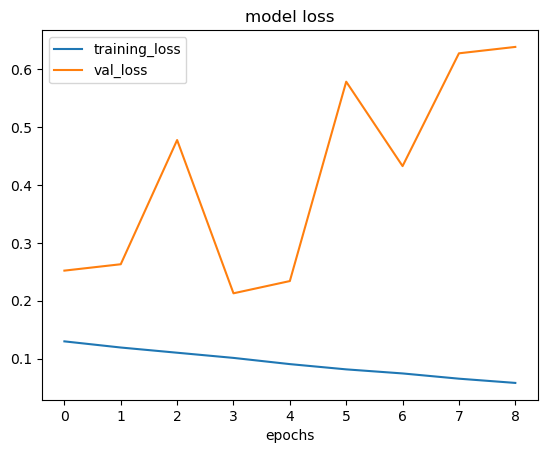

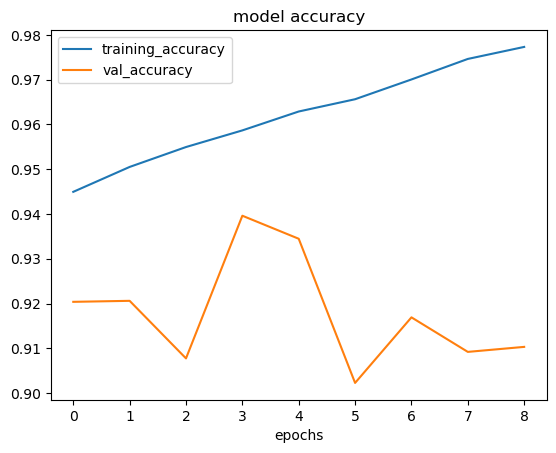

In [ ]:
plot_loss_curves(history_3)

In [ ]:
Y_pred_3 = model_2.predict(X_test)

350/350 [==============================] - 3s 7ms/step


In [ ]:
report = classification_report(y_test, np.argmax(Y_pred_3,axis = 1), zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      9719
           1       1.00      0.00      0.00      1458

    accuracy                           0.87     11177
   macro avg       0.93      0.50      0.47     11177
weighted avg       0.89      0.87      0.81     11177



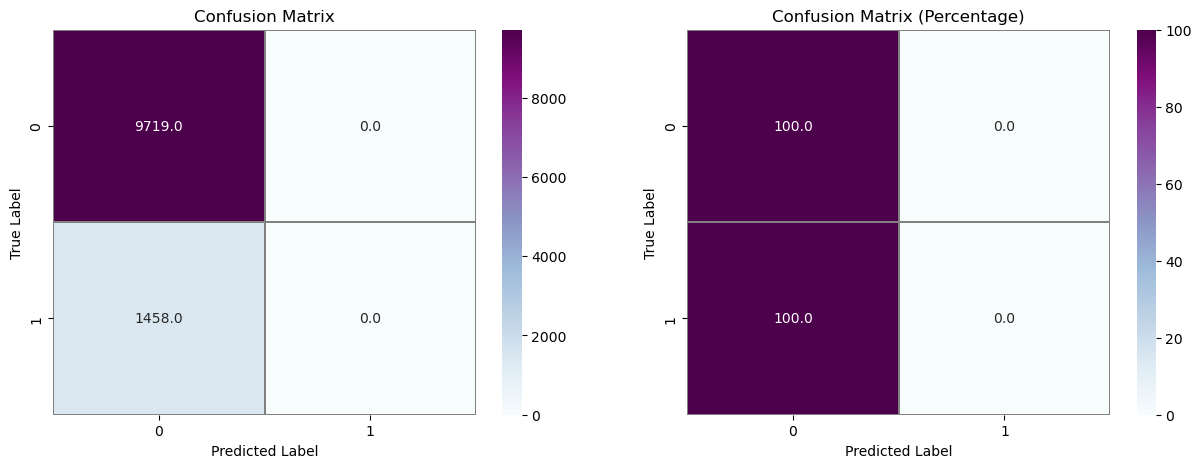

In [ ]:
visualize_conf_mat(y_test,Y_pred_3)

In [ ]:
model_2.save('model_3_mam.h5')

## Fit the model 2 on balanced data

In [ ]:
history_4 = model_2.fit(X_train_b, y_train_b, validation_split=0.2,shuffle=True, epochs=10, batch_size=62 ,callbacks=[es])

Epoch 1/10
163/163 [==============================] - 16s 89ms/step - loss: 0.2369 - accuracy: 0.9120 - val_loss: 0.5621 - val_accuracy: 0.7887
Epoch 2/10
163/163 [==============================] - 13s 78ms/step - loss: 0.1521 - accuracy: 0.9400 - val_loss: 0.7799 - val_accuracy: 0.7424
Epoch 3/10
163/163 [==============================] - 13s 79ms/step - loss: 0.1179 - accuracy: 0.9544 - val_loss: 0.3800 - val_accuracy: 0.8666
Epoch 4/10
163/163 [==============================] - 13s 79ms/step - loss: 0.0965 - accuracy: 0.9636 - val_loss: 0.6342 - val_accuracy: 0.7990
Epoch 5/10
163/163 [==============================] - 13s 79ms/step - loss: 0.0781 - accuracy: 0.9712 - val_loss: 0.4970 - val_accuracy: 0.8504
Epoch 6/10
163/163 [==============================] - 13s 79ms/step - loss: 0.0660 - accuracy: 0.9749 - val_loss: 0.4524 - val_accuracy: 0.8651
Epoch 7/10
163/163 [==============================] - 13s 78ms/step - loss: 0.0625 - accuracy: 0.9785 - val_loss: 0.7870 - val_accuracy:

## Results

In [ ]:
loss_value , accuracy = model_2.evaluate(X_test_b, y_test_b)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

99/99 [==============================] - 1s 11ms/step - loss: 0.5951 - accuracy: 0.8452
Test_loss_value = 0.595098078250885
test_accuracy = 0.8451551795005798


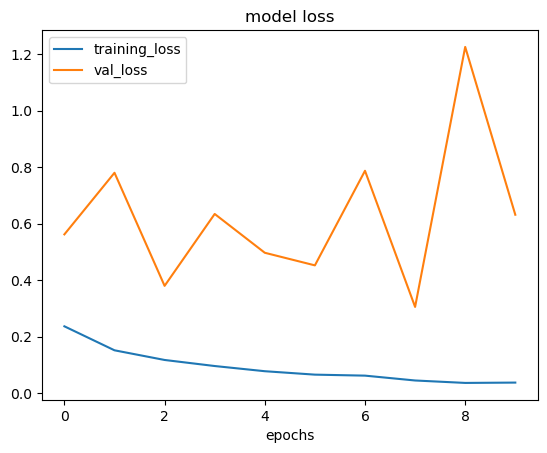

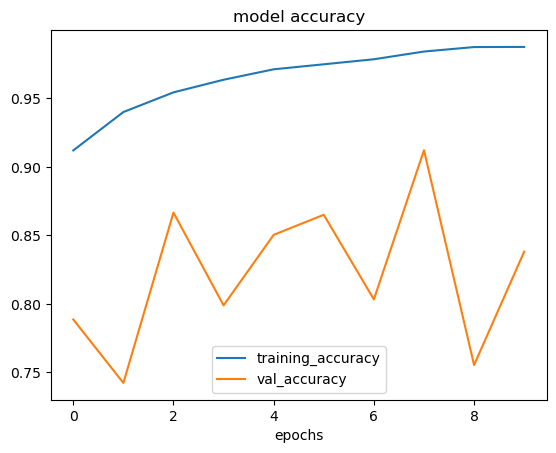

In [ ]:
plot_loss_curves(history_4)

In [ ]:
Y_pred_4 = model_2.predict(X_test_b)
report = classification_report(y_test_b, np.argmax(Y_pred_4,axis = 1), zero_division=1)
print(report)

99/99 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1700
           1       1.00      0.00      0.00      1458

    accuracy                           0.54      3158
   macro avg       0.77      0.50      0.35      3158
weighted avg       0.75      0.54      0.38      3158



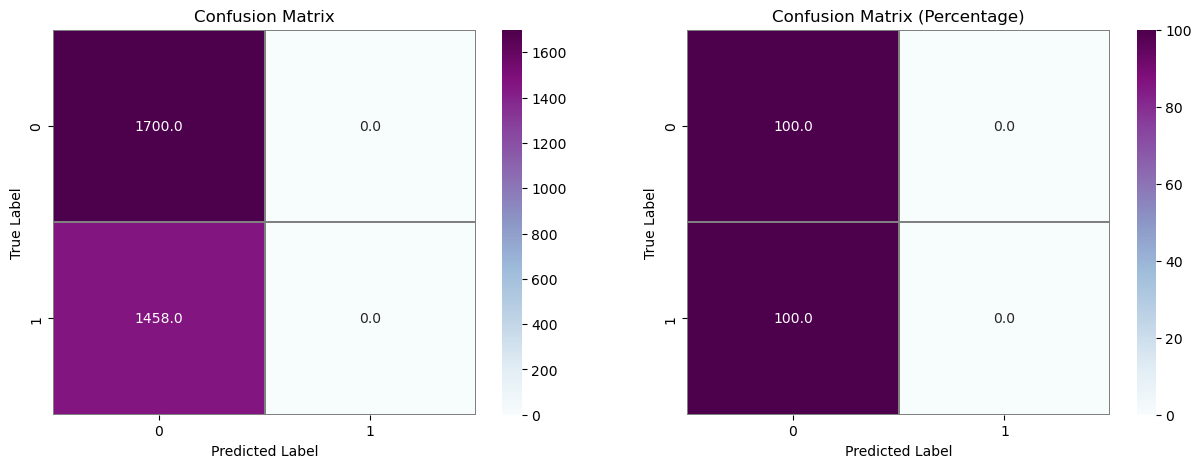

In [ ]:
visualize_conf_mat(y_test_b,Y_pred_4)

In [ ]:
model_2.save('model_4_mam.h5')

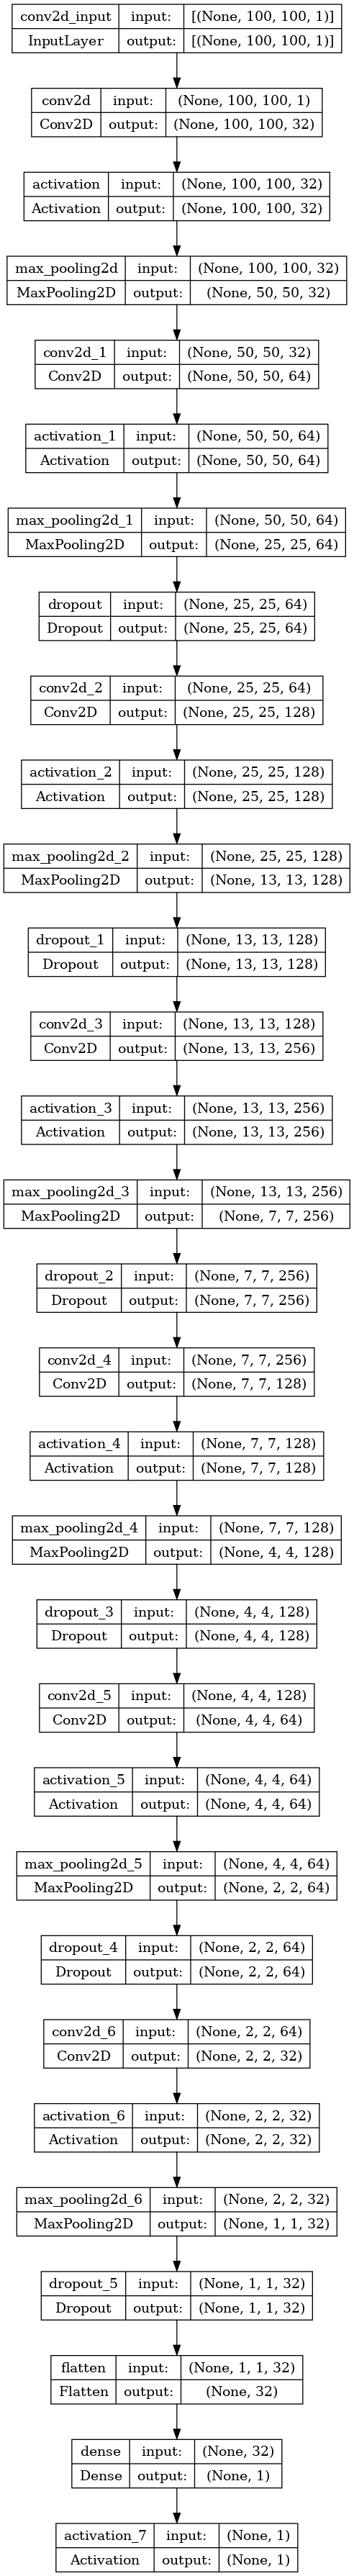

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_2_mam.png', show_shapes=True)

# Model 3 Step Decay Learning Rate Schedule

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch):
    initial_lr = 0.1  # Initial learning rate
    drop = 0.5  # Factor by which the learning rate will be reduced
    epochs_drop = 5  # Number of epochs after which learning rate will be reduced
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

In [ ]:
model_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.3),
    Dense(24, activation='relu', kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model with SGD optimizer and initial learning rate
opt = SGD(learning_rate=0.1)
model_3.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(step_decay)
# Train the model with the learning rate scheduler callback
model_3.fit(X_train_b, y_train_b,validation_split=0.2,shuffle=True, epochs=20, batch_size=64, callbacks=[lr_scheduler])

Epoch 1/20


2023-06-22 14:59:28.794461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


158/158 [==============================] - 18s 89ms/step - loss: 0.4819 - accuracy: 0.7756 - val_loss: 1.1094 - val_accuracy: 0.3629 - lr: 0.1000
Epoch 2/20
158/158 [==============================] - 13s 81ms/step - loss: 0.3991 - accuracy: 0.8201 - val_loss: 0.6424 - val_accuracy: 0.6664 - lr: 0.1000
Epoch 3/20
158/158 [==============================] - 13s 81ms/step - loss: 0.3644 - accuracy: 0.8393 - val_loss: 0.4989 - val_accuracy: 0.7531 - lr: 0.1000
Epoch 4/20
158/158 [==============================] - 13s 80ms/step - loss: 0.3459 - accuracy: 0.8449 - val_loss: 0.6426 - val_accuracy: 0.6462 - lr: 0.1000
Epoch 5/20
158/158 [==============================] - 13s 80ms/step - loss: 0.3188 - accuracy: 0.8564 - val_loss: 1.0369 - val_accuracy: 0.6636 - lr: 0.1000
Epoch 6/20
158/158 [==============================] - 13s 79ms/step - loss: 0.2974 - accuracy: 0.8708 - val_loss: 0.8085 - val_accuracy: 0.6510 - lr: 0.0500
Epoch 7/20
158/158 [==============================] - 13s 79ms/step -

## Results

In [ ]:
loss_value , accuracy = model_3.evaluate(X_test_b, y_test_b)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

99/99 [==============================] - 1s 10ms/step - loss: 0.4657 - accuracy: 0.8458
Test_loss_value = 0.46570128202438354
test_accuracy = 0.8457884788513184


In [ ]:
Y_pred_5 = model_3.predict(X_test_b)
report = classification_report(y_test_b, np.argmax(Y_pred_5,axis = 1), zero_division=1)
print(report)

99/99 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1700
           1       1.00      0.00      0.00      1458

    accuracy                           0.54      3158
   macro avg       0.77      0.50      0.35      3158
weighted avg       0.75      0.54      0.38      3158



In [ ]:
model_3.save('model_5_mam.h5')

In [ ]:
import tensorflow as tf

# Image path
image_path = '/kaggle/input/mamm-roi/data/class0/class0_image_0.png'

# Read image file
image_data = tf.io.read_file(image_path)

image = tf.io.decode_png(image_data, channels=1)  # Assuming the image is in PNG format

# Reshape and scale the image
image = tf.reshape(image, [299, 299, 1])
print(image)

tf.Tensor(
[[[152]
  [149]
  [147]
  ...
  [135]
  [135]
  [134]]

 [[152]
  [148]
  [146]
  ...
  [135]
  [136]
  [136]]

 [[149]
  [148]
  [147]
  ...
  [136]
  [136]
  [136]]

 ...

 [[103]
  [102]
  [102]
  ...
  [ 85]
  [ 88]
  [ 88]]

 [[101]
  [101]
  [101]
  ...
  [ 82]
  [ 84]
  [ 85]]

 [[ 96]
  [ 99]
  [ 99]
  ...
  [ 80]
  [ 80]
  [ 80]]], shape=(299, 299, 1), dtype=uint8)
